# Class Activation Map（CAM）
用于[State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection)

参考： https://github.com/alexisbcook/ResNetCAM-keras/blob/master/ResNet_CAM.py

In [1]:
import sys
import cv2 
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
   
from keras.models import Model, load_model
from keras.applications import VGG16, ResNet50, InceptionResNetV2, inception_resnet_v2
from keras.applications import imagenet_utils

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class_dict = {0: 'safe driving',
              1: 'texting - right',
              2: 'talking on the phone - right',
              3: 'texting - left',
              4: 'talking on the phone - left',
              5: 'operating the radio',
              6: 'drinking',
              7: 'reaching behind',
              8: 'hair and makeup',
              9: 'talking to passenger'}

In [3]:
# load image as RGB
def read_img(img_path, img_rows, img_cols):
    ori_img = cv2.imread(img_path, 1)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)      # BGR --> RGB
    ori_img = cv2.resize(ori_img, (img_rows, img_cols))
    img = np.array(ori_img, dtype=np.uint8)
    
    return img

In [4]:
# load model, and define new cam model, extract wanted output
def get_model_and_weights(model_path, model_str, conv_index):
    if(model_str=='inception_resnet_v2'):
        custom_objects = {'preprocess_input': inception_resnet_v2.preprocess_input,
                        '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input,
                        'imagenet_utils':imagenet_utils}
    else:
        custom_objects = {'preprocess_input': imagenet_utils.preprocess_input,
                        '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input}

    model = load_model(model_path, custom_objects=custom_objects)
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    model_cam = Model(inputs=model.input, 
                      outputs=(model.layers[conv_index].output, model.layers[-1].output)) 
    
    return model_cam, all_amp_layer_weights

In [5]:
def get_cam_output(model, img, img_rows, img_cols, all_amp_layer_weights, ratio):
    '''
    description: 将最后一层卷积的output与预测类别的weights相乘得到热力图
    return：final_output, ---热力图resize成input大小；
            pred, ---预测的类别号，0~9
            pred_val, ---预测的概率
    '''
    img = np.expand_dims(img, axis=0)
    last_conv_output, pred_vec =  model.predict(img)    
    last_conv_output = last_conv_output[0,:,:,:]
    
    pred = np.argmax(pred_vec)   # get prediction's index
    pred_val= pred_vec[0,pred]
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (ratio, ratio, 1), order=1)
    amp_layer_weights = all_amp_layer_weights[:, pred]
    
    final_output = np.dot(mat_for_mult.reshape((int(img_rows*img_cols), last_conv_output.shape[-1])),
                          amp_layer_weights).reshape(img_rows, img_cols)
    
    return final_output, pred, pred_val


### ResNet50

In [58]:
# set parameters
img_rows, img_cols = 224, 224
model_path = 'cache/resnet50_1-epoch10.h5'
model_str = 'resnet50'
conv_index = -4
ratio = 32

In [26]:
# load model
resnet_cam, resnet_weights = get_model_and_weights(model_path, model_str, conv_index)

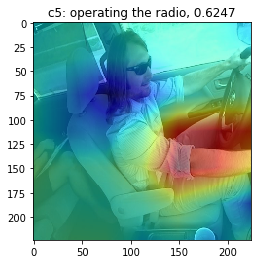

In [59]:
# predict and plot CAM
img_path = 'imgs/test/img_64.jpg'
image = read_img(img_path, img_rows, img_cols)
CAM, pred, pred_val = get_cam_output(resnet_cam, image, img_rows, img_cols, resnet_weights, ratio)

plt.imshow(image)
plt.imshow(CAM, alpha=0.5, cmap="jet")
plt.title("c{}: {}, {:.4f}".format(pred, class_dict[pred], pred_val))
plt.show()

### InceptionResnet V2

In [6]:
# set parameters
img_rows, img_cols = 299, 299
model_path = 'cache/inception_resnet_v2_1.hdf5'
model_str = 'inception_resnet_v2'
conv_index = -3
ratio = 37.375


In [7]:
# load model
inception_cam, inception_weights = get_model_and_weights(model_path, model_str, conv_index)

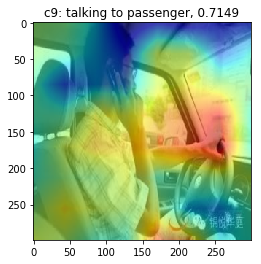

In [11]:
# predict and plot CAM
img_path = 'imgs/test03.jpg'
image = read_img(img_path, img_rows, img_cols)
CAM, pred, pred_val = get_cam_output(inception_cam, image, img_rows, img_cols, inception_weights, ratio)

plt.imshow(image)
plt.imshow(CAM, alpha=0.5, cmap="jet")
plt.title("c{}: {}, {:.4f}".format(pred, class_dict[pred], pred_val))
plt.show()